[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

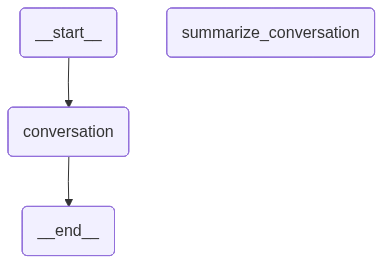

In [2]:
from IPython.display import Image, display
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [3]:
config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVI1QBeQcLOTqvwP7QOunxdtmqMK2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0517113d-2709-4d8f-b1e8-f047ef2cc423-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Let's now just print the state update.

In [5]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    if "conversation" in chunk and "messages" in chunk["conversation"]:
        message = chunk["conversation"]["messages"]
        if isinstance(message, list):
            message[-1].pretty_print()
        else:
            message.pretty_print()


================================== Ai Message ==================================

Hi Lance! It's great to meet you. How can I help you today?


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [6]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
---------------------------------------------------------------------------


### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [19]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation_node. Type: on_chain_start. Name: conversation_node
Node: conversation_node. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [6]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content='The', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' San', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' Francisco', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' ', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content='49', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content='ers', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' are', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' a', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' professional', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMessageChunk(content=' American', id='run-b76ec3b8-9c45-42fe-b321-4ec3a69c185c')}
{'chunk': AIMe

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [10]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

node_to_stream = "assistant" 

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")


### Streaming with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [21]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [11]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [12]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a260b-7a72-73fa-bd2f-866db1f2b6ed', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '982bfb5b-73c0-478c-babd-4d60e2bc1fed'}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '982bfb5b-73c0-478c-babd-4d60e2bc1fed'}, {'content': '', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-

The streamed objects have: 

* `event`: Type
* `data`: State

In [12]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} id='f51807de-6b99-4da4-a798-26cf59d16412'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': None} id='run-fa4ab1c6-274d-4be5-8c4a-a6411c7c35cc' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'type': 'tool_call'}]
content='6' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {}, 'status': 'success'} name='multiply' id='3e7bbfb6-aa82-453a-969c-9c753fbd1d74' tool_call_id='call_imZHAw7kvMR2ZeKaQVSlj25C'
conte

There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1ef6a3da-687f-6253-915a-701de5327165
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

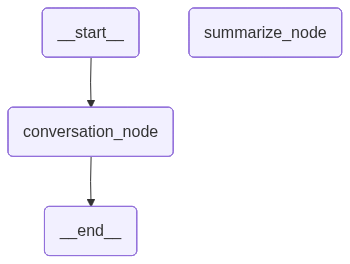

 Chat with AI (type 'exit' to stop)



You:  HELLO


AI: Hello! How can I assist you today?


You:  die


AI: I'm here to help, so if you're feeling upset or frustrated, please let me know how I can assist you. If there's something specific on your mind, feel free to share.


You:  exit


Chat ended.


In [13]:
from IPython.display import Image, display
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AnyMessage
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class State(MessagesState):
    summary: str

def conversation_node(state: State, config: RunnableConfig):
    summary = state.get("summary", "")
    messages = state["messages"]

    if summary:
        system_msg = SystemMessage(content=f"Summary so far: {summary}")
        messages = [system_msg] + messages

    response = model.invoke(messages, config)
    return {"messages": [response]}

def summarize_node(state: State):
    summary = state.get("summary", "")
    summary_prompt = (
        f"This is the current summary: {summary}\n\n"
        "Update it based on the latest conversation."
        if summary else "Summarize the conversation above briefly."
    )

    messages = state["messages"] + [HumanMessage(content=summary_prompt)]
    response = model.invoke(messages)

    to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": to_remove}

def continue_condition(state: State):
    if len(state["messages"]) > 6:
        return "summarize_node"
    return END

workflow = StateGraph(State)
workflow.add_node("conversation_node", conversation_node)
workflow.add_node("summarize_node", summarize_node)
workflow.add_edge(START, "conversation_node")
workflow.add_conditional_edges("conversation_node", continue_condition)
workflow.add_edge("summarize_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id": "1"}}

print(" Chat with AI (type 'exit' to stop)\n")

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Chat ended.")
        break

    output = graph.invoke({"messages": [HumanMessage(content=user_input)]}, config)
    ai_reply = output["messages"][-1].content
    print("AI:", ai_reply)

    state = graph.get_state(config)
    if state.values.get("summary"):
        print("\n Summary so far:")
        print(state.values["summary"])
        print("-" * 60)


In [14]:
config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation_node': {'messages': [AIMessage(content='Hi Lance! Nice to meet you! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 75, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVIPSUmKwy2G2vHKMReYhSTxKVQqF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--36306684-5bd7-40a5-8547-258354c1a480-0', usage_metadata={'input_tokens': 75, 'output_tokens': 15, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [15]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    if "conversation" in chunk and "messages" in chunk["conversation"]:
        message = chunk["conversation"]["messages"]
        if isinstance(message, list):
            message[-1].pretty_print()
        else:
            message.pretty_print()


In [16]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! How can I assist you today?
---------------------------------------------------------------------------


In [17]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation_node. Type: on_chain_start. Name: conversation_node
Node: conversation_node. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation_node. Type: on_chat_model

In [18]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

In [19]:

config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

node_to_stream = "assistant" 

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

In [20]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")


In [21]:
assistants = await client.assistants.search()


In [22]:
thread = await client.threads.create()
input_message = HumanMessage(content="Write java code to add 2+3")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)
 

StreamPart(event='metadata', data={'run_id': '019a2616-abc9-7704-a9ce-2144d24dae16', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Write java code to add 2+3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '90fd93db-c771-4847-93cf-b1101f94ed2f'}]})
StreamPart(event='values', data={'messages': [{'content': 'Write java code to add 2+3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '90fd93db-c771-4847-93cf-b1101f94ed2f'}, {'content': 'Here is a simple Java program that adds 2 and 3:\n\n```java\npublic class AddNumbers {\n    public static void main(String[] args) {\n        int a = 2;\n        int b = 3;\n        int sum = a + b;\n        System.out.println("The sum of 2 and 3 is: " + sum);\n    }\n}\n```\n\nThis program defines two integer variables `a` and `b`, adds them together, and prints the result.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usag

In [23]:
from langchain_core.messages import convert_to_messages
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=" * 25)


content='Write java code to add 2+3' additional_kwargs={} response_metadata={} id='a7c0a84c-de0a-4013-9398-ecaa20c4d7cb'
content='Here is the Java code to add 2 and 3:\n\n```java\npublic class AddTwoNumbers {\n    public static void main(String[] args) {\n        int result = 2 + 3;\n        System.out.println("The sum of 2 and 3 is: " + result);\n    }\n}\n```\n\nThis program calculates the sum of 2 and 3 and prints the result.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 254, 'output_tokens': 83, 'total_tokens': 337, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 254, 'total_tokens': 337, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'mod

In [24]:
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)


metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
mess